In [1]:
import os, sys

In [2]:
'SUMO_HOME' in os.environ

True

In [3]:
tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
sys.path.append(tools)

In [4]:
sumoBinary = "C:/Program Files (x86)/DLR/Sumo/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "C:/Users/sreeniva/Desktop/Reinforcement Learning/madrl_traffic_control/Sumo Stuff/hello.sumocfg"]

In [5]:
import traci

In [6]:
traci.start(sumoCmd)

(15, 'SUMO 0.30.0')

In [7]:
import traci
import math
from collections import defaultdict

CAR_WIDTH = 5
MAX_HEIGHT = 200 / CAR_WIDTH
MAX_LENGTH = 200 / CAR_WIDTH
lane_ids = ["left-right-1_0", "left-right-2_0",
            "right-left-1_0", "right-left-2_0",
            "up-down-1_0", "up-down-2_0",
            "down-up-1_0", "down-up-2_0", ]


def get_left_right_dtse(x_min, x_max, y):
    vehicle_vel = 0  # default
    vehicle_present = -1  # default
    vehicle_id = -999
    n_blocks = int(math.ceil(abs(x_max - x_min) / CAR_WIDTH))
    dtse_map = [[vehicle_present, vehicle_vel, vehicle_id] for x in range(n_blocks)]
    vehicle_ids = traci.vehicle.getIDList()
    for vehicle_id in vehicle_ids:
        (x_pos, y_pos) = traci.vehicle.getPosition(vehicle_id)
        vehicle_vel = traci.vehicle.getSpeed(vehicle_id)
        if x_pos > x_min and x_pos < x_max and y_pos == y:
            # make sure blocks are equally spaced starting from the junction
            block = int((x_max - x_pos) / CAR_WIDTH)
            # print x_pos, y_pos, block
            dtse_map[block] = [1, vehicle_vel, vehicle_id]
    return dtse_map


def get_right_left_dtse(x_min, x_max, y):
    vehicle_vel = 0  # default
    vehicle_present = -1  # default
    vehicle_id = -999
    n_blocks = int(math.ceil(abs(x_max - x_min) / CAR_WIDTH))
    dtse_map = [(vehicle_present, vehicle_vel, vehicle_id) for x in range(n_blocks)]
    vehicle_ids = traci.vehicle.getIDList()
    for vehicle_id in vehicle_ids:
        (x_pos, y_pos) = traci.vehicle.getPosition(vehicle_id)
        vehicle_vel = traci.vehicle.getSpeed(vehicle_id)
        if x_pos > x_min and x_pos < x_max and y_pos == y:
            block = int((x_pos - x_min) / CAR_WIDTH)
            # print x_pos, y_pos, block
            dtse_map[block] = [1, vehicle_vel, vehicle_id]
    return dtse_map


def get_up_down_dtse(y_min, y_max, x):
    vehicle_vel = 0  # default
    vehicle_present = -1  # default
    vehicle_id = -999
    n_blocks = int(math.ceil(abs(y_max - y_min) / CAR_WIDTH))
    dtse_map = [(vehicle_present, vehicle_vel, vehicle_id) for y in range(n_blocks)]
    vehicle_ids = traci.vehicle.getIDList()
    for vehicle_id in vehicle_ids:
        (x_pos, y_pos) = traci.vehicle.getPosition(vehicle_id)
        vehicle_vel = traci.vehicle.getSpeed(vehicle_id)
        if y_pos > y_min and y_pos < y_max and x_pos == x:
            # make sure blocks are equally spaced starting from the junction
            block = int((y_pos - y_min) / CAR_WIDTH)
            # print x_pos, y_pos, block
            dtse_map[block] = [1, vehicle_vel, vehicle_id]
    return dtse_map


def get_down_up_dtse(y_min, y_max, x):
    vehicle_vel = 0  # default
    vehicle_present = -1  # default
    vehicle_id = -999
    n_blocks = int(math.ceil(abs(y_max - y_min) / CAR_WIDTH))
    dtse_map = [(vehicle_present, vehicle_vel, vehicle_id) for y in range(n_blocks)]
    vehicle_ids = traci.vehicle.getIDList()
    for vehicle_id in vehicle_ids:
        (x_pos, y_pos) = traci.vehicle.getPosition(vehicle_id)
        vehicle_vel = traci.vehicle.getSpeed(vehicle_id)
        if y_pos > y_min and y_pos < y_max and x_pos == x:
            # make sure blocks are equally spaced starting from the junction
            block = int((y_max - y_pos) / CAR_WIDTH)
            # print x_pos, y_pos, block
            dtse_map[block] = [1, vehicle_vel, vehicle_id]

    return dtse_map


def normalize_dtse(dtse):
    max_vel = 0
    for (vehicle_present, vehicle_vel, vehicle_id) in dtse:
        max_vel = max(max_vel, vehicle_vel)
    # avoid divide by zero
    if max_vel == 0:
        max_vel = 1
    normalized_dtse = [[vehicle_present, (vehicle_vel/max_vel), vehicle_id] for (vehicle_present, vehicle_vel, vehicle_id) in dtse]
    return normalized_dtse


def get_dtse_for_junction():
    # NOTE: all outgoing lanes have been commented because DTSE
    # should be calculated only for incoming lanes

    # left-right-1
    [(x_min, y), (x_max, y1)] = traci.lane.getShape('left-right-1_0')
    lr_1_dtse = get_left_right_dtse(x_min, x_max, y)

    # # left-right-2  # block size will be wrong near the junction
    # [(x_min, y), (x_max, y1)] = traci.lane.getShape('left-right-2_0')
    # lr_2_dtse = get_left_right_dtse(x_min, x_max, y)

    # right-left-1
    [(x_max, y), (x_min, y1)] = traci.lane.getShape('right-left-1_0')
    rl_1_dtse = get_left_right_dtse(x_min, x_max, y)

    # # right-left-2  # block size will be wrong near the junction
    # [(x_max, y), (x_min, y1)] = traci.lane.getShape('right-left-2_0')
    # rl_2_dtse = get_left_right_dtse(x_min, x_max, y)

    # up-down-1
    [(x, y_max), (x1, y_min)] = traci.lane.getShape('up-down-1_0')
    ud_1_dtse = get_up_down_dtse(y_min, y_max, x)

    # # up-down-2  # block size will be wrong near the junction
    # [(x, y_max), (x1, y_min)] = traci.lane.getShape('up-down-2_0')
    # ud_2_dtse = get_up_down_dtse(y_min, y_max, x)

    # down-up-1
    [(x, y_min), (x1, y_max)] = traci.lane.getShape('down-up-1_0')
    du_1_dtse = get_down_up_dtse(y_min, y_max, x)

    # # down-up-2  # block size will be wrong near the junction
    # [(x, y_min), (x1, y_max)] = traci.lane.getShape('down-up-2_0')
    # du_2_dtse = get_down_up_dtse(y_min, y_max, x)

    dtse_list = [lr_1_dtse, rl_1_dtse, ud_1_dtse, du_1_dtse]
    normalized_dtse_list = []

    for dtse in dtse_list:
        normalized_dtse_list.append(normalize_dtse(dtse))

    return normalized_dtse_list


min_speed = 0.1
# call this at every step
# this function uses too much space because of the dict
def get_avg_waiting_time_v1(vehicle_wait_times):
    avg_wait_time = 0.0
    vehicle_ids = traci.vehicle.getIDList()
    for vehicle_id in vehicle_ids:
        if traci.vehicle.getSpeed(vehicle_id) < 0.1:
            vehicle_wait_times[vehicle_id] += 1
 
    total_waiting_time = sum(vehicle_wait_times.values())  # sum over dictionary
    n_vehicles = len(vehicle_wait_times.keys())
    avg_wait_time = total_waiting_time / n_vehicles if n_vehicles > 0 else 0

    return avg_wait_time


# total_waiting_time = 0
# total_moving_time = 0
# call this at every step
# total_moving_time = (gamma * total_moving_time) + total_moving_time
def get_avg_waiting_frac(total_waiting_time, total_moving_time, gamma = 1.0):
    total_moving_time, total_waiting_time
    vehicle_ids = traci.vehicle.getIDList()
    for vehicle_id in vehicle_ids:
        if traci.vehicle.getSpeed(vehicle_id) < 0.1:
            total_waiting_time = gamma * total_waiting_time + 1
        else:
            total_moving_time = gamma * total_moving_time + 1

    avg_wait_frac = total_waiting_time / (total_waiting_time + total_moving_time) if len(vehicle_ids) > 0 else 0
    return avg_wait_frac


def my_plot(data, x_label='time', y_label='average waiting fraction'):
    plt.plot(data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


# define the agent's action
# pass the green duration for the next phase
# NOTE: make sure to call this only at the beginning of the phase or else
#       you may end up resetting the existing phase duration
# default green duration is 31s
def act(green_duration):
    tls = traci.trafficlights.getIDList()[0]
    curr_phase = traci.trafficlights.getPhase(tls)
    # we can change the duration only at the beginning of phases 0, 3, 6, 9
    if curr_phase % 3 == 0:
        print "setting phase to {}".format(green_duration)
        traci.trafficlights.setPhaseDuration(tls, green_duration)


gamma_avg_wait_frac_list = defaultdict(list)
avg_waiting_time_list = []
def test_workflow():
    vehicle_wait_times = defaultdict(lambda: 0.0)
    step = 0
    while step < 1000:
        # this represents the avg_waiting_frac the last time we took an action
        vehicle_wait_times = run_sim_step(step, vehicle_wait_times)
        step += 1


def run_sim_step(step, vehicle_wait_times):
    tls = traci.trafficlights.getIDList()[0]
    prev_phase = traci.trafficlights.getPhase(tls)
    
    # get avg_waiting_time from previous action till now
    avg_waiting_time = get_avg_waiting_time_v1(vehicle_wait_times)
    avg_waiting_time_list.append(avg_waiting_time)

    total_waiting_time = defaultdict(lambda: 0)
    total_moving_time = defaultdict(lambda: 0)
    for gamma in [0.1*x for x in range(1, 11)]:
        gamma_avg_wait_frac_list[gamma].append(get_avg_waiting_frac(total_waiting_time[gamma], total_moving_time[gamma], gamma))

    traci.simulationStep()
    curr_phase = traci.trafficlights.getPhase(tls)

    if (curr_phase != prev_phase) and (curr_phase % 3 == 0):
        # reset everyone's waiting time
        vehicle_wait_times = defaultdict(lambda: 0.0)

        # phase has changed and the agent needs to do something!
        # get DTSE
#         dtse = get_dtse_for_junction()

        # compute reward
        # if it has reduced, we get a postive reward!
        reward = avg_waiting_time
#         print "reward!", reward

        # act!
        # act(20)

    return vehicle_wait_times

In [8]:
test_workflow()

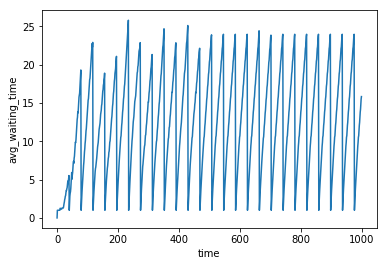

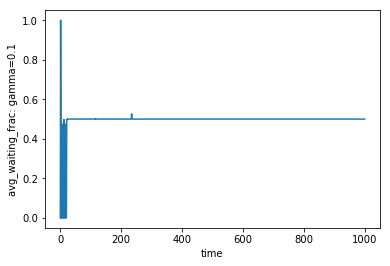

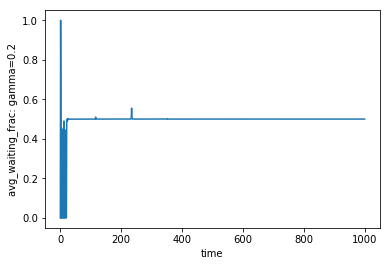

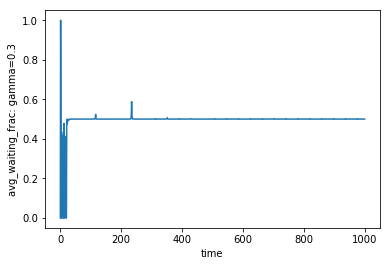

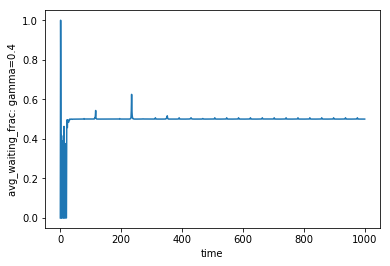

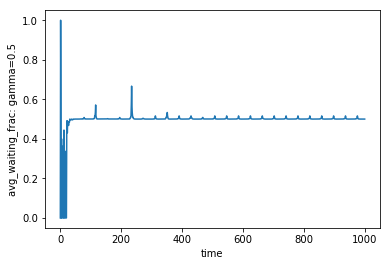

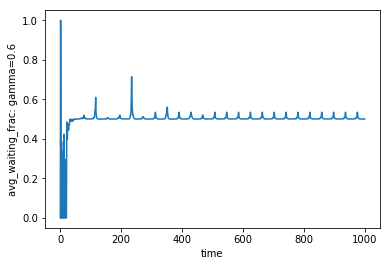

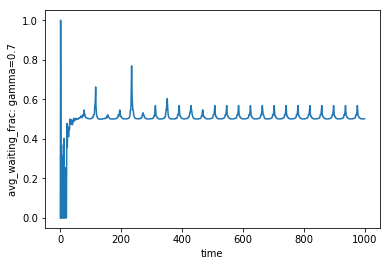

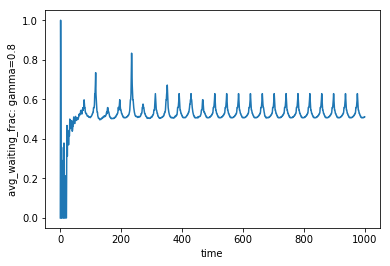

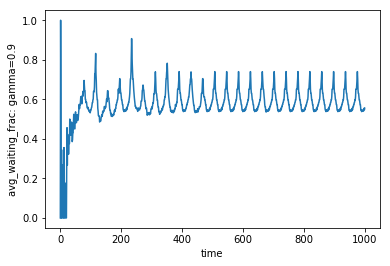

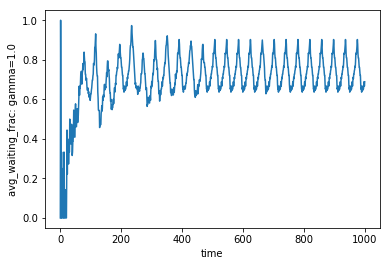

In [9]:
from matplotlib import pyplot as plt
x_label='time'
y_label='average waiting fraction'

plt.plot(avg_waiting_time_list)
plt.xlabel(x_label)
plt.ylabel('avg_waiting_time')
plt.show()

for gamma in [0.1*x for x in range(1, 11)]:
    plt.plot(gamma_avg_wait_frac_list[gamma])
    plt.xlabel(x_label)
    plt.ylabel('avg_waiting_frac: gamma={}'.format(gamma))
    plt.show()
